Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END clf__bootstrap=False, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=302, clf__random_state=42; total time=   0.2s
[CV] END clf__bootstrap=False, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=302, clf__random_state=42; total time=   0.2s
[CV] END clf__bootstrap=False, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=302, clf__random_state=42; total time=   0.2s
[CV] END clf__bootstrap=False, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=302, clf__random_state=42; total time=   0.2s
[CV] END clf__bootstrap=False, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=6, clf__n_estimators=302, clf__random_state=42; total time=

/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

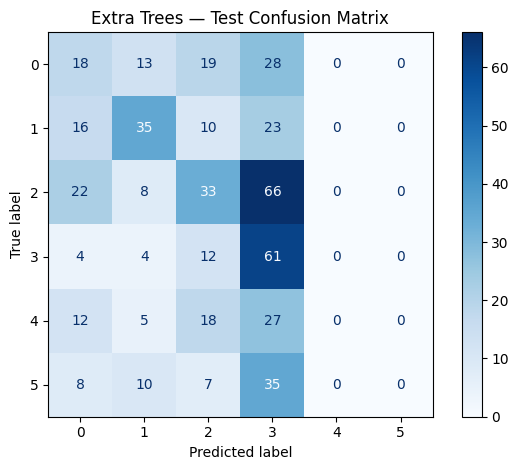

Test Set AUC (OvR): 0.6677

== Confidence Decile Table ==
      Top %  N Samples  Correct Predictions  Accuracy in Decile  \
0   Top 10%         49                   21               0.429   
1   Top 20%         98                   37               0.378   
2   Top 30%        148                   52               0.351   
3   Top 40%        197                   74               0.376   
4   Top 50%        247                   88               0.356   
5   Top 60%        296                  102               0.345   
6   Top 70%        345                  112               0.325   
7   Top 80%        395                  125               0.316   
8   Top 90%        444                  135               0.304   
9  Top 100%        494                  147               0.298   

   Avg Confidence  
0           0.425  
1           0.399  
2           0.381  
3           0.366  
4           0.353  
5           0.342  
6           0.333  
7           0.324  
8           0.315  
9   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from scipy.stats import randint

# -----------------------------
# 1. Load and Prepare Data
# -----------------------------
train_df = pd.read_csv("../data/generated_data/train.csv")
test_df = pd.read_csv("../data/generated_data/test.csv")

drop_cols = ["date"]
train_df = train_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

train_df['regime_today'] = train_df['regime']
test_df['regime_today'] = test_df['regime']

train_df['regime_t+3'] = train_df['regime'].shift(-3)
test_df['regime_t+3'] = test_df['regime'].shift(-3)

train_df = train_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])
test_df = test_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])

# -----------------------------
# 2. Feature / Target Split
# -----------------------------
X_train = train_df.drop(columns=['regime_t+3'])
y_train = train_df['regime_t+3'].astype(int) - 1

X_test = test_df.drop(columns=['regime_t+3'])
y_test = test_df['regime_t+3'].astype(int) - 1

# -----------------------------
# 3. Scale Features
# -----------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. Extra Trees Optimization
# -----------------------------
pipeline_et = Pipeline([
    ('clf', ExtraTreesClassifier())
])

param_distributions_et = {
    'clf__n_estimators': randint(200, 600),
    'clf__max_depth': [None] + list(range(5, 25, 5)),
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 11),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__bootstrap': [False, True],
    'clf__random_state': [42],
}

search_et = RandomizedSearchCV(
    estimator=pipeline_et,
    param_distributions=param_distributions_et,
    n_iter=100,
    scoring='roc_auc_ovr',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search_et.fit(X_train_scaled, y_train)

print("\n== Best Extra Trees Params ==")
print(search_et.best_params_)
print(f"Best CV AUC (OvR): {search_et.best_score_:.4f}")

best_et = search_et.best_estimator_

# -----------------------------
# 5. Evaluate on Test Set
# -----------------------------
y_pred_test = best_et.predict(X_test_scaled)
y_test_proba = best_et.predict_proba(X_test_scaled)

print("\n== Extra Trees — TEST Accuracy Report ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap="Blues", values_format="d")
plt.title("Extra Trees — Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Test AUC
auc_score = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
print(f"Test Set AUC (OvR): {auc_score:.4f}")

# -----------------------------
# 6. Confidence-Based Decile Analysis
# -----------------------------
confidences = y_test_proba.max(axis=1)
y_pred = np.argmax(y_test_proba, axis=1)

eval_df = pd.DataFrame({
    "true": y_test + 1,
    "pred": y_pred + 1,
    "conf": confidences
})

eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(int)
eval_df = eval_df.sort_values("conf", ascending=False).reset_index(drop=True)

decile_results = []
n = len(eval_df)
total_correct = eval_df["correct"].sum()

for d in range(10, 110, 10):  # Deciles: 10% to 100%
    cutoff = int((d / 100) * n)
    subset = eval_df.iloc[:cutoff]
    n_samples = len(subset)
    n_correct = subset["correct"].sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    avg_conf = subset["conf"].mean() if n_samples > 0 else 0

    decile_results.append({
        "Top %": f"Top {d}%",
        "N Samples": n_samples,
        "Correct Predictions": n_correct,
        "Accuracy in Decile": round(accuracy, 3),
        "Avg Confidence": round(avg_conf, 3)
    })

decile_df = pd.DataFrame(decile_results)
print("\n== Confidence Decile Table ==")
print(decile_df)
